# Infant Vision Acuity Simulation

In [1]:
# Import Libraries
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import random

In [3]:
# Define the Custom Infant Vision Dataset Class
class InfantVision(Dataset):
    def __init__(self, imagenet_subset, ages_in_months, transform=None, use_transform=True):  # use_transform is a flag to see if blurs are neededd
        self.imagenet_subset = imagenet_subset # A subset of the dataset (in this case 100 random images)
        self.ages_in_months = ages_in_months
        self.transform = transform
        self.use_transform = use_transform

    def _age_to_blur(self, age_in_months):
        if age_in_months <= 2:
            return 4  # Maximum blur for newborns (0-2 months)
        elif age_in_months <= 4:
            return 3  # Blur for infants aged 2-4 months
        elif age_in_months <= 6:
            return 2  # Blur for infants aged 4-6 months
        elif age_in_months <= 9:
            return 1  # Blur for infants aged 6-9 months
        else:
            return 0  # No blur for infants older than 9 months

    def _apply_gaussian_blur(self, image, sigma):
        if self.transform and sigma > 0:
            return image.filter(ImageFilter.GaussianBlur(radius=sigma))
        else:
            return image  # No blur applied

    def __len__(self):
        return len(self.imagenet_subset)

    def __getitem__(self, idx):
        image, _ = self.imagenet_subset[idx]
        age_in_months = self.ages_in_months[idx]
        sigma = self._age_to_blur(age_in_months)
        
        # Apply Gaussian blur based on age
        image = self._apply_gaussian_blur(image, sigma)
        
        # Apply transformations, including resizing
        if self.transform:
            image = self.transform(image)
        
        return image, age_in_months

In [4]:
# Load CIFAR-100 and select a subset of images
transform = transforms.Compose([
    # transforms.Resize((112, 112)),  # Resize images to 112x112 to match the paper
    transforms.ToTensor(),          # Convert to tensor
])

# Set path to your ImageNet Mini dataset
imagenet_path = "D:/Uni/WS24-25/Computational Visual Preception/imagenet-mini/archive/imagenet-mini"  # path to mini imagenet
imagenet_data = ImageFolder(root=imagenet_path)

# Select a random subset of 100 images
subset_indices = random.sample(range(len(imagenet_data)), 100)
imagenet_subset = torch.utils.data.Subset(imagenet_data, subset_indices)

In [5]:
# Give ages in months for each image, randomly
ages_in_months = [random.choice([0, 2, 4, 6, 9, 12]) for _ in range(len(imagenet_subset))]

In [6]:
# Instantiate the Infant Vision Dataset with CIFAR-100 Subset
infant_vision_dataset = InfantVision(imagenet_subset, ages_in_months, transform=transform)
dataloader = DataLoader(infant_vision_dataset, batch_size=1, shuffle=False)

In [7]:
# Convert Tensors to PIL Images (for Visualization)
def tensor_to_pil(image_tensor):
    image_tensor = image_tensor.squeeze()  # remove batch dimension
    image = transforms.ToPILImage()(image_tensor)
    return image

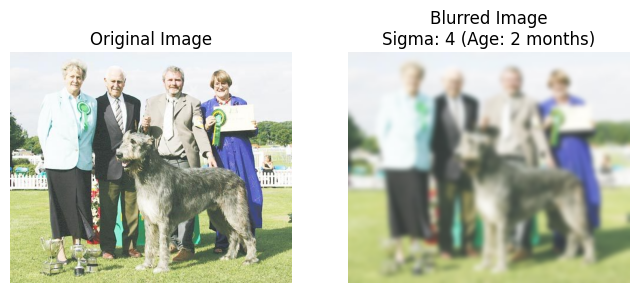

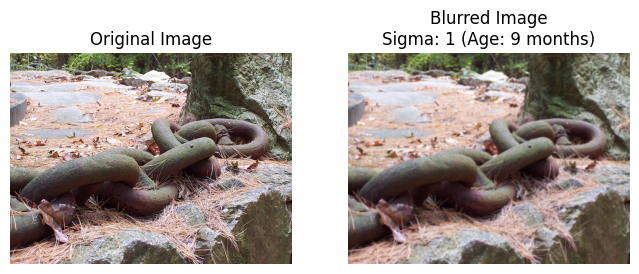

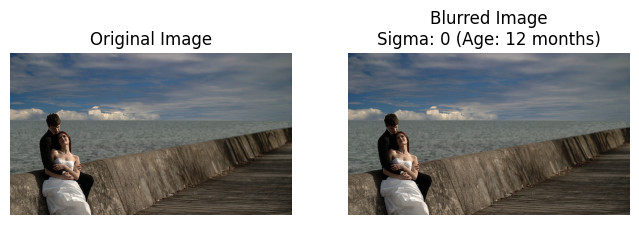

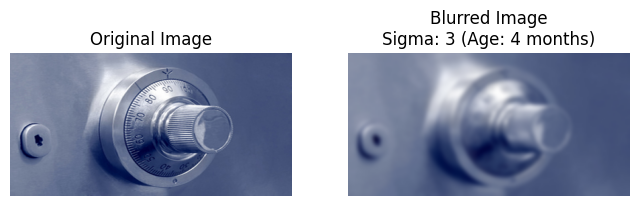

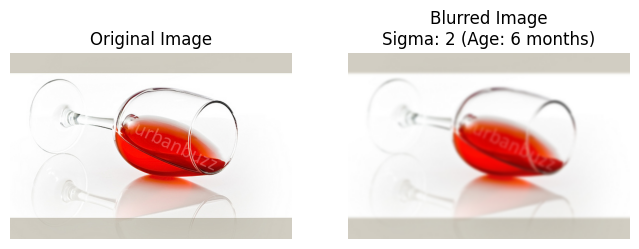

In [8]:
# Display Original and Blurred Examples for Each Sigma Level
displayed_sigmas = set()

for i, (image, age) in enumerate(dataloader):
    sigma = infant_vision_dataset._age_to_blur(age.item())
    
    # Only display if this sigma level hasn't been shown yet
    if sigma not in displayed_sigmas:
        # Retrieve the original, unaltered image
        original_image, _ = imagenet_subset[i]
        
        # Convert both original and blurred images to displayable format
        original_pil_image = transforms.ToPILImage()(transforms.ToTensor()(original_image))
        blurred_pil_image = transforms.ToPILImage()(image.squeeze(0))
        
        # Display side by side for comparison
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(original_pil_image)
        axs[0].set_title("Original Image")
        axs[0].axis('off')
        
        axs[1].imshow(blurred_pil_image)
        axs[1].set_title(f"Blurred Image\nSigma: {sigma} (Age: {age.item()} months)")
        axs[1].axis('off')
        
        plt.show()
        
        # Mark this sigma level as displayed
        displayed_sigmas.add(sigma)
    
    # Stop once we've displayed all sigma levels
    if len(displayed_sigmas) == 5:
        break

# Evalutation

In [9]:
import time

# Function to measure total data loading time
def measure_total_loading_time(dataloader):
    start_time = time.time()
    for _ in dataloader:
        pass  # Simulate the loading of data
    end_time = time.time()
    return end_time - start_time

In [13]:
infant_vision_dataset_without_transform = InfantVision(
    imagenet_subset,  # Subset of 100 random images
    ages_in_months,   # Corresponding ages in months
    transform=transform,    # Transform to tensor
    use_transform=False # To surprass the use of the transforms (gaussian blurs)
)

In [14]:

# Measure loading time with transformation
dataloader_with_transform = DataLoader(infant_vision_dataset, batch_size=1, shuffle=False)
time_with_transform = measure_total_loading_time(dataloader_with_transform)

# Measure loading time without transformation
dataloader_without_transform = DataLoader(infant_vision_dataset_without_transform, batch_size=1, shuffle=False)
time_without_transform = measure_total_loading_time(dataloader_without_transform)

# Print the results
print(f"Time taken with transformation: {time_with_transform:.2f} seconds")
print(f"Time taken without transformation: {time_without_transform:.2f} seconds")


Time taken with transformation: 0.85 seconds
Time taken without transformation: 0.84 seconds
